# A single-compartment neuron with Hodgkin & Huxley and transient K+ conductances


## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [21]:
# Fetch mechanisms (if you haven't already)
!git clone https://github.com/ABL-Lab/NSC6084-A23.git

Cloning into 'NSC6084-A22'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 41 (delta 10), reused 32 (delta 4), pack-reused 0
Unpacking objects: 100% (41/41), 324.94 KiB | 2.80 MiB/s, done.


In [4]:
# Compile the mechanisms (if you haven't already)
# Note: recompiled mechanisms will not take effect until the jupyter kernel is restarted
!nrnivmodl ./NSC6084-A23/Sept19/mechanisms

/home/emuller/nC/teaching/NSC6084_CompNeuro/Fall_2022/NSC6084-A22-git/Sept20
Mod files: "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/CaDynamics_DC0.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/Ca_HVA2.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/Ca_LVAst.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/SK_E2.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [4]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s

In [5]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [6]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [7]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [8]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [9]:
soma.L = 10 * um
soma.diam =  10 * um

In [10]:
volume = soma(0.5).volume() * um**3

In [11]:
area = soma(0.5).area() * um**2

In [12]:
area

array(314.15926536) * um**2

In [13]:
volume

array(785.3981634) * um**3

### Assign the membrane capacitance "everywhere"

In [14]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [15]:
specific_membrane_capacitance = 1 * uF/cm**2

In [16]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add the Hodgkin-Huxley conductances

In [17]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("hh")

__nrnsec_0x322d020

That's almost too easy!

### Parametize the leak conductance G = 1/R

In [18]:
G = 1 * nS  # R = 1/G in our RC circuit

In [19]:
v_rest = -70*mV

In [20]:
tau_m = soma(0.5).cm / soma(0.5).hh.gl

In [21]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [22]:
tau_m

array(3.14159265) * ms

In [23]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.hh.gl = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.hh.el = -54.3

### Inspect our parameters

In [24]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.00031830988618379076],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x322d020',
 'hoc_internal_name': '__nrnsec_0x322d020',
 'cell': None}

In [25]:
soma.nseg

1

### Add a current injection

In [26]:
stim = h.IClamp(soma(0.5))

In [27]:
stim.delay = 200 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 600 * ms  # stop injecting current at 520ms 
stim.amp = 0.032 * nA  # Inject 0.1 nA of current

## Step 3: Run the simulation

### Define recordings of simulation variables

In [28]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [29]:
# Record hh gating variables
hh_vars = ['h', 'm', 'n', 'gna', 'gk']
hh_recordings = {}
for var in hh_vars:
    ref = getattr(soma(0.5).hh, "_ref_"+var )
    hh_recordings[var] = h.Vector().record(ref) 

In [30]:
hh_recordings

{'h': Vector[2],
 'm': Vector[3],
 'n': Vector[4],
 'gna': Vector[5],
 'gk': Vector[6]}

### Run the simulation

In [31]:
h.finitialize( float(v_rest) )
h.continuerun( float(1000 * ms) )

0.0

## Step 4: Plot the results

(0.0, 1000.0, -80.0, 30.0)

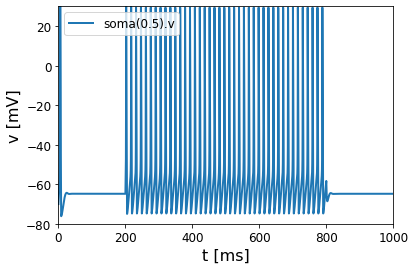

In [32]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([0,1000,-80,30])

(195.0, 220.0, 0.0, 1.0)

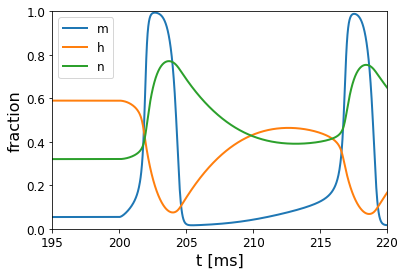

In [33]:
plt.plot(t, hh_recordings['m'], lw=2, label="m")
plt.plot(t, hh_recordings['h'], lw=2, label="h")
plt.plot(t, hh_recordings['n'], lw=2, label="n")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("fraction", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([195,220,0,1])

(195.0, 220.0, 0.0, 0.05)

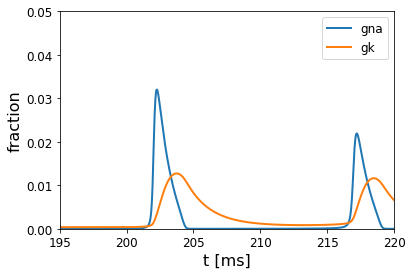

In [34]:
plt.plot(t, hh_recordings['gna'], lw=2, label="gna")
plt.plot(t, hh_recordings['gk'], lw=2, label="gk")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("fraction", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([195,220,0, 0.05])

In [35]:
def find_spikes(v, t):
    """ Returns times of spikes for a voltage trace and time grid"""
    
    # look for upward crossing of 0mV
    v_arr = np.array(v)
    t_arr = np.array(t) 
    # This is tricky & powerful notation! Let's discuss in class!
    return t_arr[1:][(v_arr[1:]>0) & (v_arr[:-1]<0)] 

In [36]:
spike_times = find_spikes(soma_v, t)

In [37]:
spike_times, len(spike_times)

(array([  4.975, 201.925, 216.85 , 231.5  , 246.15 , 260.8  , 275.45 ,
        290.1  , 304.725, 319.375, 334.025, 348.675, 363.325, 377.975,
        392.6  , 407.25 , 421.9  , 436.55 , 451.2  , 465.85 , 480.475,
        495.125, 509.775, 524.425, 539.075, 553.725, 568.35 , 583.   ,
        597.65 , 612.3  , 626.95 , 641.6  , 656.225, 670.875, 685.525,
        700.175, 714.825, 729.475, 744.1  , 758.75 , 773.4  , 788.05 ]),
 42)

In [38]:
firing_freq = (len(spike_times)/(stim.dur*ms)).rescale(Hz)

In [39]:
firing_freq

array(70.) * Hz

(200.0, 400.0, -80.0, 30.0)

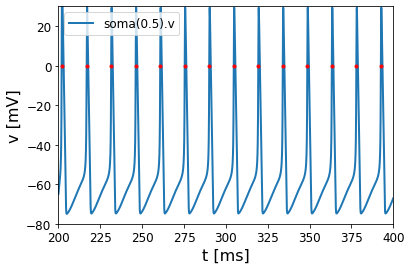

In [40]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot(spike_times, len(spike_times)*[0], 'r.')
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([200,400,-80,30])

## Now it's your turn!

### **Question 1** 
Create a function to return the firing frequency for a given current input I, and plot the firing frequency for a range of currents from 0 to 0.1 nA (e.g. steps of 0.001 nA)



In [41]:
I_range = np.arange(0,0.1,0.001)

In [42]:
def find_freq(I):
    stim.amp = I
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    spike_times = find_spikes(soma_v, t)
    firing_freq = (len(spike_times[spike_times>200])/(stim.dur*ms)).rescale(Hz)
    return firing_freq

In [43]:
# Note this cool notation: List comprehension
freqs = [find_freq(x) for x in I_range]

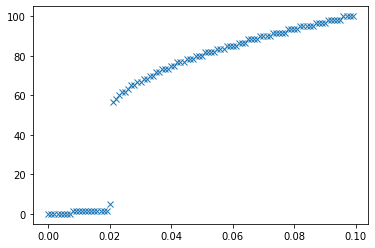

In [44]:
plt.plot(I_range, freqs, 'x')
#plt.axis([0.01, 0.02, 0, 100])

In [45]:
#soma.insert("K_Tst")
#soma(0.5).K_Tst.gK_Tstbar = 0.1*0.477

In [45]:
soma.insert("Kv4_2_0016")
soma(0.5).Kv4_2_0016.gKv4_2bar = 0.1*0.8
h.celsius = 6.3

In [46]:
soma(0.5).Kv4_2_0016.q10 = 3.0

In [47]:
#soma(0.5).K_Tst.gK_Tstbar = 0
#soma(0.5).hh.gkbar = 0.036
#soma(0.5).Kv4_2_0016.gKv4_2bar = 0

In [48]:
# Note this cool notation: List comprehension
freqs = [find_freq(x) for x in I_range]

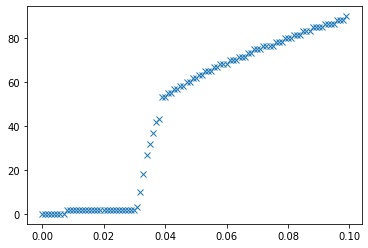

In [49]:
plt.plot(I_range, freqs, 'x')
#plt.axis([0.01, 0.02, 0, 100])

In [67]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.020000000000000004],
   'gl': [0.00031830988618379076],
   'el': [-54.3],
   'gna': [6.524758406189811e-05],
   'gk': [0.00033928031905585456],
   'il': [-0.0013919043126473423],
   'minf': [0.10880303876592848],
   'hinf': [0.3713123661262273],
   'ninf': [0.41832086361416165],
   'mtau': [0.317623305264396],
   'htau': [7.298610082968743],
   'ntau': [5.039914527328111],
   'm': [0.10251074433409886],
   'h': [0.5119545334621678],
   'n': [0.3611802273200836]},
  'K_Tst': {'gK_Tstbar': [0.0477],
   'ik': [4.087603605644702e-06],
   'gK_Tst': [2.2303476769459705e-07],
   'm': [0.06949073497796197],
   'h': [0.20217978822044452]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [-0.00709063741594374],
   'dina_dv_': [6.524758406224046e-05]},
  'k': {'ek': [-77.0],
   'ki': [140.0],
   'ko': [5.0],
   'ik': [0.006222147100930339],
   'dik_dv_': [0.00033